# Causal inference continuous treatment
In which we try to estimate the effect of continuous treatment (different kinds of dissemination) on the outcome (frequency change) using the `causaldrf` package ([here](https://cran.r-project.org/web/packages/causaldrf/vignettes/Using_causaldrf.pdf)).

In [1]:
library(causaldrf)

Let's do a toy example with synthetic data.

In [2]:
set.seed(123)
data_sampler <- function(N) {
    X1 <- rexp(N)
    X2 <- rexp(N)
    T <- rexp(N, X1 + X2)
    gps <- (X1 + X2) * exp(-(X1+X2)*T)
    Y <- T + gps + rnorm(N)
    df <- data.frame(cbind(X1, X2, T, gps, Y))
    return(df)
}
N <- 1000
sample_data <- data_sampler(N)

In [3]:
head(sample_data)

X1,X2,T,gps,Y
0.84345726,0.2234968,1.91349201,0.1385117,1.5180197
0.57661027,0.1176255,0.00688635,0.6909247,1.4721957
1.32905487,3.0515370,0.57383280,0.3546785,0.4528899
0.03157736,0.4905639,1.29120147,0.2660671,1.5328412
0.05621098,2.0381937,0.05176272,1.8792209,2.9499917
0.31650122,0.3129919,0.32857206,0.5118753,-0.3651330


In [162]:
# original code
# hi_estimate <- hi_est(Y='Y',
#                       treat='T',
#                       treat_formula=T ~ X1 + X2,
#                       outcome_formula=Y ~ T + I(T^2) + gps + I(gps^2) + T*gps,
#                       data=sample_data,
#                       grid_val=quantile(sample_data$T, 
#                                         probs=seq(0, 0.95, by=0.01)),
#                       treat_mod='Gamma',
#                       link_function='inverse')
quant_probs <- seq(0, 0.95, by=0.01)
treat_formula <- as.formula(paste('T', paste(c('X1','X2'), sep = '+'), sep = '~'))
outcome_formula <- as.formula(paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~'))
grid_val <- quantile(sample_data[,'T'], probs=quant_probs)
treat_mod <- 'Gamma'
link_function <- 'inverse'
hi_estimate <- hi_est(Y='Y',
                      treat='T',
                      treat_formula=as.formula(treat_formula),
                      outcome_formula=as.formula(outcome_formula),
                      data=sample_data,
                      grid_val=grid_val,
                      treat_mod='Gamma',
                      link_function='inverse')

In [143]:
print(hi_estimate)


Estimated values:
 [1] 2.081874 2.029189 1.992119 1.962105 1.936472 1.902608 1.877294 1.844788
 [9] 1.793034 1.765013 1.742412 1.725442 1.709316 1.695419 1.673777 1.638334
[17] 1.625586 1.596654 1.582365 1.564497 1.552889 1.539819 1.520318 1.506452
[25] 1.479430 1.458394 1.431899 1.416917 1.405909 1.395052 1.380632 1.359410
[33] 1.349073 1.337427 1.325389 1.309003 1.299928 1.292572 1.277591 1.260045
[41] 1.245958 1.232271 1.219366 1.210793 1.201509 1.190258 1.182790 1.178075
[49] 1.170570 1.162085 1.154655 1.146035 1.138437 1.133048 1.126406 1.121307
[57] 1.118013 1.113804 1.111203 1.110477 1.110567 1.111442 1.113995 1.117201
[65] 1.120759 1.125266 1.131994 1.134731 1.139386 1.145005 1.163964 1.188710
[73] 1.207590 1.235220 1.250860 1.286013 1.324124 1.358233 1.395916 1.435381
[81] 1.458410 1.490391 1.552602 1.607650 1.671063 1.737951 1.838290 1.927955
[89] 2.004687 2.080178 2.172372 2.277996 2.385746 2.549100 2.877377 3.089994


In [90]:
hi_estimate$t_mod


Call:  glm(formula = formula_t, family = Gamma(link = link_function), 
    data = samp_dat)

Coefficients:
(Intercept)           X1           X2  
     0.1120       0.8468       0.9175  

Degrees of Freedom: 999 Total (i.e. Null);  997 Residual
Null Deviance:	    1724 
Residual Deviance: 1171 	AIC: 1195

In [91]:
hi_estimate$out_mod


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T       I(T^2)          gps     I(gps^2)        T:gps  
   0.016092     1.001029    -0.003928     0.990436     0.019131    -0.013017  


Now let's interpret these results!

- For the `t_mod` test, it appears that the covariates X1 and X2 contribute almost equally to the treatment likelihood (treatment function). This makes sense since the treatment was generated from an exponential distribution with lambda equal to the sum of covariates: $T \sim \mathcal{f}(X1+X2)$
- For the `out_mod` test, it appears that the GPS and treatment values contribute almost equally to the outcome, with less importance on the squared and interaction terms. This makes sense since the outcome generation function was $Y = T + GPS$.

## Now on real data
Now let's fit a simple model to our data and see how well the treatment response is measured.

For our purposes, we want to consider as "treatment" the following variables:

- linguistic dissemination ($D^{L}$)
- user dissemination ($D^{U}$)
- subreddit dissemination ($D^{S}$)
- thread dissemination ($D^{T}$)

To keep it simple, let's use a single covariate:

- frequency at time $t$ ($f_{t}$)

The outcome is the change in frequency between time $t$ and time $t+k$:

- $\Delta_{f, t:t+k}$

Let's arbitrarily define $t=12$ and $k=12$, to start.

In [2]:
t <- 12
k <- 12

In [3]:
f <- read.table('../../data/frequency/2013_2016_tf_norm_log.tsv', sep = '\t', row.names = 1, header = TRUE, check.names = FALSE)

In [4]:
print(head(f))

         2013-06   2013-07   2013-08   2013-09   2013-10   2013-11   2013-12
just   -2.267228 -2.264805 -2.266678 -2.268449 -2.268265 -2.267388 -2.267818
like   -2.295678 -2.295178 -2.296224 -2.299470 -2.300128 -2.301271 -2.301898
can    -2.409923 -2.413153 -2.410532 -2.413738 -2.408188 -2.398326 -2.394363
one    -2.444079 -2.455069 -2.455124 -2.457127 -2.453421 -2.446522 -2.450686
get    -2.471086 -2.466172 -2.461398 -2.463402 -2.453960 -2.459005 -2.459616
people -2.490445 -2.489400 -2.493693 -2.504749 -2.502038 -2.507595 -2.511400
         2014-01   2014-02   2014-03   2014-04   2014-05   2014-06   2014-07
just   -2.270001 -2.269298 -2.268909 -2.265839 -2.268946 -2.267834 -2.267565
like   -2.299020 -2.298666 -2.298165 -2.297007 -2.297898 -2.297053 -2.295580
can    -2.394979 -2.397980 -2.397843 -2.399743 -2.398136 -2.397937 -2.395979
one    -2.453414 -2.457965 -2.458524 -2.458582 -2.459189 -2.459970 -2.458717
get    -2.462385 -2.462762 -2.464554 -2.461102 -2.462024 -2.460414 -2.459055

In [5]:
DL <- read.table('../../data/frequency/2013_2016_3gram_residuals.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DU <- read.table('../../data/frequency/2013_2016_user_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE, )
DS <- read.table('../../data/frequency/2013_2016_subreddit_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DT <- read.table('../../data/frequency/2013_2016_thread_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)

In [6]:
# get overlapping vocab
all_stats <- list(f, DL, DU, DS, DT)
all_idx <- sapply(all_stats, row.names)
vocab <- Reduce(intersect, all_idx)

In [7]:
f <- f[vocab,]
DL <- DL[vocab,]
DU <- DU[vocab,]
DS <- DS[vocab,]
DT <- DT[vocab,]

In [9]:
f_t <- f[, t]
f_outcome <- f[, t+k] - f[, t]

In [10]:
complete_data <- cbind(f_t, DL[, t], DU[, t], DS[, t], DT[, t], f_outcome)
complete_data <- as.data.frame(complete_data)
complete_data[is.na(complete_data)] <- 0
t_vars <- c('DL', 'DU', 'DS', 'DT')
c_vars <- c('f')
o_var <- 'f_delta'
colnames(complete_data) <- c(c_vars, t_vars, c(o_var))
head(complete_data)
tail(complete_data)

f,DL,DU,DS,DT,f_delta
-2.268946,-0.3163648,0.9870318,0.9526390,0.9757385,0.002147264
-2.297898,-0.2338869,0.9845934,0.9674209,0.9723791,0.003469932
-2.398136,-0.3708324,0.9492436,0.9558420,0.9584724,0.001758100
-2.459189,-0.3159086,0.9875305,0.9802809,0.9570168,-0.005483717
-2.462024,-0.4088417,0.9665840,0.9459889,0.9497413,0.005643103
-2.506601,-0.3617842,0.7883153,0.8028347,0.6867699,0.001236781


,f,DL,DU,DS,DT,f_delta
99992,-6.970919,-0.32475265,0.8194179,0.41536870,0.6447399,-0.15940390
99993,-7.248290,-0.23622987,0.9419518,0.48988878,0.5486888,-0.07929209
99994,-7.323823,-0.07331923,0.7200312,0.30947251,0.5002309,0.02112297
99995,-7.481175,-0.11196142,0.4880879,0.09298721,0.3334400,0.15359263
99996,-7.202285,0.20873435,0.9839301,0.75282885,0.8555958,0.08792581
99997,-7.340645,0.19239055,0.9146595,0.73314932,0.8603819,0.08920779


Testing each treatment at a time, let's do the estimation procedure.

In [13]:
quant_probs <- seq(0, 0.95, by=0.01)
treat_mod <- 'Gamma'
link_function <- 'inverse'
for(t_var in t_vars){
    print(paste('testing var ', t_var, sep = ''))
    tmp_data <- as.data.frame(cbind(complete_data[, t_var], complete_data[, c_vars], complete_data[, o_var]))
    colnames(tmp_data) <- c('T', c_vars, 'Y')
    treat_formula <- as.formula(paste('T', paste(c_vars, sep = '+'), sep = '~'))
    outcome_formula <- as.formula(paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~'))
    grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
    hi_estimate <- hi_est(Y=Y,
                          treat=T,
                          treat_formula=T ~ f,
                          outcome_formula=Y ~ T + gps,
                          data=tmp_data,
                          grid_val=grid_val,
                          # these need to be hard coded for some reason??
                          # Gamma can't handle negative stuff
#                           treat_mod='Gamma',
                          treat_mod='Normal',
                          link_function='inverse')
    print(hi_estimate$t_mod)
    print(hi_estimate$out_mod)
}
# hi_estimate <- hi_est(Y=Y,
#                       treat=T,
#                       treat_formula=T ~ X1 + X2,
#                       outcome_formula=Y ~ T + I(T^2) + gps + I(gps^2) + T*gps,
#                       data=sample_data,
#                       grid_val=quantile(sample_data$T, 
#                                         probs=seq(0, 0.95, by=0.01)),
#                       treat_mod='Gamma',
#                       link_function='inverse')

[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   0.013691     0.002078  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.07074     -0.06386     -0.02725  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   0.813523     0.002712  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.22170     -0.17964     -0.02345  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
    0.89530      0.05911  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
  0.0258248    0.0102478    0.0004079  

[1] "testing var DT"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   0.666345    -0.007513 

OK! I wish we had some statistical strength tests because some of these trends are interesting.

- negative correlation with DL
- negative correlation with DU
- positive correlation with DS
- (weak) negative correlation with DT

What happens if, for each treatment variable, we use the other variables as covariates? Will that make the story different? There's a fair amount of collinearity between the social stuff.

In [14]:
grid_val <- seq(0, 0.95, by=0.01)
treat_mod <- 'Normal'
link_function <- 'inverse'
all_vars <- c('f', 'DL', 'DU', 'DS', 'DT')
for(t_var in t_vars){
    print(paste('testing var ', t_var, sep = ''))
    c_vars <- Filter(function(x) { return(x != t_var)}, all_vars)
    tmp_data <- as.data.frame(cbind(complete_data[, t_var], complete_data[, c_vars], complete_data[, o_var]))
    colnames(tmp_data) <- c('T', c_vars, 'Y')
    grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
    # attempts to automatically generate formulae
    treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
    outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
#     treat_formula <- formula(paste('T', paste(c_vars, collapse = '+'), sep = '~'))
#     outcome_formula <- formula(paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~'))
#     treat_formula <- reformulate(paste(c_vars, collapse = '+'), response='T')
#     outcome_formula <- reformulate(paste(c('T', 'gps'), collapse = '+'), response='Y')
    # even hard-coding the formulae doesn't work!! what do??
#     treat_formula <- T ~ f + DS + DT + DU
#     outcome_formula <- Y ~ T + gps
#     hi_estimate <- hi_est(Y=Y,
#                           treat=T,
#                           treat_formula=treat_formula,
#                           outcome_formula=outcome_formula,
#                           data=tmp_data,
#                           grid_val=grid_val,
#                           # these need to be hard coded for some reason??
#                           # Gamma can't handle negative stuff
# #                           treat_mod='Gamma',
#                           treat_mod='Normal',
#                           link_function='inverse')
    # horrible solution: convert estimator command to text and parse
    hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
    hi_estimate <- eval(parse(text=hi_est_str))
    print(hi_estimate$t_mod)
    print(hi_estimate$out_mod)
}

[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DU           DS           DT  
 -0.2941815   -0.0004739    0.0244459    0.0828418    0.3208811  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.037600    -0.085632    -0.003672  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DS           DT  
   0.340356     0.004657     0.005486     0.048821     0.644385  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.214789    -0.206337    -0.005092  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DU           DT  
    0.11891      0.06615      0.05139      0.13494      0.99935  


Call:
lm(formula = outcome_formula, data = tempdat

OK! With respect to frequency change:

- DL has negative correlation
- DU has strong negative correlation
- DS has weak positive
- DT has weak negative

We want to build a table where the rows are treatment variables, columns are timespans (12 and 24, same as in relative importance), and cells are coefficients (with significance).

## Generalize to all t+k values

Let's test the same thing but with all data pairs $t$ and $t+k$.

This requires flattening the data...AWESOME.

In [9]:
# reload because kernel was borked
library(causaldrf)
f <- read.table('../../data/frequency/2013_2016_tf_norm_log.tsv', sep = '\t', row.names = 1, header = TRUE, check.names = FALSE)
DL <- read.table('../../data/frequency/2013_2016_3gram_residuals.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DU <- read.table('../../data/frequency/2013_2016_user_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE, )
DS <- read.table('../../data/frequency/2013_2016_subreddit_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
DT <- read.table('../../data/frequency/2013_2016_thread_diffusion.tsv', sep = '\t', row.names = 1, quote = "", header = TRUE, check.names = FALSE)
# get overlapping vocab
all_stats <- list(f, DL, DU, DS, DT)
all_idx <- sapply(all_stats, row.names)
vocab <- Reduce(intersect, all_idx)
# restrict to vocab
f <- f[vocab,]
DL <- DL[vocab,]
DU <- DU[vocab,]
DS <- DS[vocab,]
DT <- DT[vocab,]

In [56]:
library(reshape2)
all_stats <- list(f=f, DL=DL, DS=DS, DU=DU, DT=DT)
s_names <- names(all_stats)
all_stats_flat <- data.frame()
for(s_name in s_names){
    s <- all_stats[[s_name]]
    s_flat <- s
    s_flat[, 'word'] <- rownames(s_flat)
    s_flat <- melt(s_flat, id.var='word', variable.name='time', value.name=s_name)
#     all_stats_flat[, s_name] <- s_flat[, s_name]
    s_flat_vec <- s_flat[, s_name]
    s_flat_df <- data.frame(s_name=s_flat_vec)
    colnames(s_flat_df) <- c(s_name)
    if(length(all_stats_flat) == 0){
        all_stats_flat <- s_flat_df
    }
    else{
        all_stats_flat <- cbind(all_stats_flat, s_flat_df)
    }
}
# replace nan values
all_stats_flat[is.na(all_stats_flat)] <- 0
# add word/time columns to all stats flat
word_time <- all_stats[['f']]
word_time[, 'word'] <- rownames(word_time)
word_time <- melt(word_time, id.var='word', variable.name='time')[, c('word', 'time')]
all_stats_flat <- cbind(all_stats_flat, word_time)
print(head(all_stats_flat))

          f         DL        DS        DU        DT   word    time
1 -2.267228 -0.3633401 0.9707535 0.9895004 0.9803800   just 2013-06
2 -2.295678 -0.2904082 0.9785251 0.9894286 0.9857771   like 2013-06
3 -2.409923 -0.4124010 0.9658959 0.9391187 0.9420672    can 2013-06
4 -2.444079 -0.3668837 0.9747492 0.9956675 0.9595533    one 2013-06
5 -2.471086 -0.4495569 0.9591620 0.9673060 0.9564756    get 2013-06
6 -2.490445 -0.4014034 0.8096224 0.7968290 0.6926202 people 2013-06


Wait! We also need the deltas for k-month offsets. UGH!!

In [57]:
# this actually might not be so bad if we can do a proper merge on word/time
# update: doesn't take too long to merge
N <- length(f)
k_vals <- c(N / 6, N / 3, N * (2/3))
print(k_vals)
stats_combined <- all_stats_flat
for(k in k_vals){
    f_0 <- f[, 1:(N-k)]
    f_k <- f[, (k+1):N]
    print(dim(f_0))
    print(dim(f_k))
    f_delta_k <- f_k - f_0
    colnames(f_delta_k) <- colnames(f_0)
    f_delta_k[, 'word'] <- rownames(f_delta_k)
    s_name <- paste('f_delta_', k, sep='')
    print(paste('computing ', s_name))
    f_delta_k_flat <- melt(f_delta_k, id.var='word', variable.name='time', value.name=s_name)
    stats_combined <- merge(stats_combined, f_delta_k_flat, by=c('word', 'time'))
}

[1]  6 12 24
[1] 99997    30
[1] 99997    30
[1] "computing  f_delta_6"
[1] 99997    24
[1] 99997    24
[1] "computing  f_delta_12"
[1] 99997    12
[1] 99997    12
[1] "computing  f_delta_24"


In [58]:
print(head(stats_combined))

  word    time         f         DL        DS        DU        DT  f_delta_6
1   aa 2013-06 -4.759620 -0.2721676 0.4259636 0.5838445 0.4937120 0.03541463
2   aa 2013-07 -4.773509 -0.2759661 0.4328117 0.5950137 0.5008167 0.03278649
3   aa 2013-08 -4.744809 -0.2816542 0.4293650 0.5848677 0.4851003 0.02866319
4   aa 2013-09 -4.772042 -0.2693710 0.4356467 0.5848808 0.5041282 0.08836694
5   aa 2013-10 -4.727054 -0.2716384 0.4133832 0.5729915 0.4817333 0.03263522
6   aa 2013-11 -4.712972 -0.2645208 0.4211694 0.5777986 0.4871397 0.04202354
    f_delta_12 f_delta_24
1  0.063266979 0.07583363
2  0.088272804 0.11538628
3  0.036725367 0.06045035
4  0.066927005 0.08506597
5 -0.002919784 0.05006502
6 -0.024909560 0.03591527


Now do the same average dose response test for each combination of k-values and treatment variables.

In [64]:
print(hi_estimate[['out_mod']][['coefficients']][['(Intercept)']])

[1] 0.2886049


In [100]:
t_vars <- c('DL', 'DU', 'DS', 'DT')
c_vars <- c('f')
c_var_str <- paste(c_vars, collapse=',')
quant_probs <- seq(0, 0.95, by=0.01)
k_vals <- c(N / 6, N / 3, N * (2/3))
# organize in a single data frame
hi_est_df <- data.frame()
hi_est_colnames <- c('k', 'treatment_name', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
for(k in k_vals){
    print(paste(c('testing k=', k), collapse=''))
    o_var <- paste(c('f_delta_', k), collapse='')
    for(t_var in t_vars){
        print(paste('testing var ', t_var, sep = ''))
        tmp_data <- as.data.frame(cbind(stats_combined[, t_var], stats_combined[, c_vars], stats_combined[, o_var]))
        colnames(tmp_data) <- c('T', c_vars, 'Y')
        # only include valid cases
        tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
        grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
        # automatically generate formulae
        treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
        outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
        # convert estimator command to text and parse
        hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
        hi_estimate <- eval(parse(text=hi_est_str))
        print(hi_estimate$t_mod)
        print(hi_estimate$out_mod)
        hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
        hi_est_row <- c(k, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']])
        hi_est_row <- t(data.frame(hi_est_row))
        if(length(hi_est_df) == 0){
            hi_est_df <- hi_est_row
        }
        else{
            hi_est_df <- as.data.frame(rbind(hi_est_df, hi_est_row))
        }
    }
}
hi_est_colnames <- c('k', 'treatment_name', 'control_names', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
colnames(hi_est_df) <- hi_est_colnames

[1] "testing k=6"
[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   0.016538     0.002504  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.029770    -0.048499    -0.001444  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
     0.8809       0.0121  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.10432     -0.04620     -0.02028  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
    0.89021      0.05574  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.027923     0.008805    -0.004303  

[1] "testing var DT"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
  0.715

ERROR: Error in 1:dim(hi_est_colnames)[1]: argument of length 0


In [104]:
rownames(hi_est_df) <- 1:dim(hi_est_df)[1]

In [106]:
print(hi_est_df)

    k treatment_name control_names      treatment_coeff            gps_coeff
1   6             DL             f   -0.048498834375443 -0.00144414795129995
2   6             DU             f  -0.0462022391263251  -0.0202768712637021
3   6             DS             f   0.0088045840571263 -0.00430296201565224
4   6             DT             f   0.0213050274052294 -0.00775406650060631
5  12             DL             f   -0.104936823138841   -0.013769296838611
6  12             DU             f    -0.22427630258253  -0.0461322398035936
7  12             DS             f  -0.0326181089500329  -0.0319872107448398
8  12             DT             f  -0.0884035687572895  -0.0434543468771216
9  24             DL             f   -0.164384277097795  -0.0376684792371175
10 24             DU             f   -0.354454122872586  -0.0693092114004065
11 24             DS             f -0.00573317730950622  -0.0327324640886275
12 24             DT             f   -0.154554803626123  -0.0712659773755869

OK! We see that:

- strong negative correlation with $DL$
- strong negative correlation with $DU$
- weak correlation with $DS$
- weak positive/negative correlation with $DT$

Same test, but using all possible covariates as control measures.

In [109]:
hi_est_all_covariates_df <- data.frame()
all_vars <- c('f', 'DL', 'DS', 'DU', 'DT')
hi_est_colnames <- c('k', 'treatment_name', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
for(k in k_vals){
    print(paste(c('testing k=', k), collapse=''))
    o_var <- paste(c('f_delta_', k), collapse='')
    for(t_var in t_vars){
        print(paste('testing var ', t_var, sep = ''))
        c_vars <- Filter(function(x) { return(x != t_var)}, all_vars)
        tmp_data <- as.data.frame(cbind(stats_combined[, t_var], stats_combined[, c_vars], stats_combined[, o_var]))
        colnames(tmp_data) <- c('T', c_vars, 'Y')
        # only include valid cases
        tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
        grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
        # automatically generate formulae
        treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
        outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
        # convert estimator command to text and parse
        hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
        hi_estimate <- eval(parse(text=hi_est_str))
        print(hi_estimate$t_mod)
        print(hi_estimate$out_mod)
        hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
        hi_est_row <- c(k, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']])
        hi_est_row <- t(data.frame(hi_est_row))
        if(length(hi_est_df) == 0){
            hi_est_all_covariates_df <- hi_est_row
        }
        else{
            hi_est_all_covariates_df <- as.data.frame(rbind(hi_est_all_covariates_df, hi_est_row))
        }
    }
}
hi_est_colnames <- c('k', 'treatment_name', 'control_names', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
colnames(hi_est_all_covariates_df) <- hi_est_colnames
rownames(hi_est_all_covariates_df) <- 1:dim(hi_est_all_covariates_df)[1]

[1] "testing k=6"
[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DS           DU           DT  
  -0.292118    -0.002890     0.096348     0.006133     0.304005  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
  0.0260938   -0.0508183    0.0009988  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DS           DT  
   0.372707     0.010615     0.001525     0.028522     0.674794  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.100003    -0.062289    -0.006382  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DU           DT  
    0.10869      0.05484      0.06370      0.07581      0.99762  


Call:
lm(formula = outcome_formu

In [110]:
hi_est_all_covariates_df

k,treatment_name,control_names,treatment_coeff,gps_coeff,intercept_coeff
6,DL,f,-0.0508182967571605,0.000998787856269658,0.0260938323631098
6,DU,f,-0.0622890849869564,-0.00638178170217348,0.100002692229426
6,DS,f,0.0472506094440379,-0.0538266172317089,0.114317180020823
6,DT,f,0.0255673142884836,-0.00534436985515247,0.028957054016265
12,DL,f,-0.127657596342949,0.0101215975351168,0.0319628592163112
12,DU,f,-0.269389578167437,-0.0118366766938454,0.305878896218454
12,DS,f,0.0244030084964897,-0.0860538762475729,0.213819671498545
12,DT,f,-0.102229767063967,-0.0108603596482021,0.161357995693326
24,DL,f,-0.201435468222534,0.00287980345924693,0.0611603692071496
24,DU,f,-0.432073039324555,-0.0146827877965328,0.463802887631695


Similar results as before?

- DL has consistently negative coefficient
- DS has weak positive coefficient
- DT has negative coefficient in later weeks

## Restrict to success/failure words
Same test, but now with just the success and failure words.

In [116]:
# load success and failure words from file FML
success_file <- '../../data/frequency/word_lists/2013_2016_growth_words_clean.csv'
success_words <- as.character(read.csv(success_file, header=TRUE)[, 'word'])
fail_file <- '../../data/frequency/word_lists/2013_2016_growth_decline_combined.csv'
fail_words <- as.character(read.csv(fail_file, header=TRUE)[, 'word'])
print(head(success_words))
print(head(fail_words))

[1] "ab"       "abit"     "abt"      "abusable" "accs"     "accts"   
[1] "pbjs"        "fawk"        "scrappy"     "equalities"  "userscripts"
[6] "totes"      


In [117]:
all_change_words <- c(success_words, fail_words)
print(length(all_change_words))

[1] 2050


In [118]:
'af' %in% all_change_words

[1] TRUE

In [126]:
change_rows <- mapply(function(x) { return(x %in% all_change_words)}, stats_combined[, 'word'])
stats_combined_change_words <- stats_combined[change_rows, ]
print(head(stats_combined_change_words))

    word    time         f          DL        DS        DU        DT
817   ab 2013-06 -5.273302 -0.05925666 0.5974675 0.7204191 0.6539763
818   ab 2013-07 -5.260812 -0.05713851 0.6068202 0.7300389 0.6284788
819   ab 2013-08 -5.230353 -0.08201955 0.5941738 0.6935076 0.6226387
820   ab 2013-09 -5.248889 -0.08075226 0.5720117 0.6916183 0.6309110
821   ab 2013-10 -5.239302 -0.07800725 0.5680596 0.6770247 0.5763900
822   ab 2013-11 -5.328865 -0.04959558 0.6104148 0.7303542 0.6742172
       f_delta_6  f_delta_12 f_delta_24
817 -0.013320985 0.057400171  0.2036800
818 -0.032033146 0.062278653  0.2407351
819 -0.003898049 0.004195805  0.2130993
820 -0.018895710 0.059427722  0.2381894
821  0.052784644 0.063352198  0.3117501
822  0.143962820 0.126412678  0.3558597


Now do the same tests that we did before.

In [127]:
# frequency only
t_vars <- c('DL', 'DU', 'DS', 'DT')
c_vars <- c('f')
c_var_str <- paste(c_vars, collapse=',')
quant_probs <- seq(0, 0.95, by=0.01)
k_vals <- c(N / 6, N / 3, N * (2/3))
# organize in a single data frame
hi_est_change_df <- data.frame()
hi_est_colnames <- c('k', 'treatment_name', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
for(k in k_vals){
    print(paste(c('testing k=', k), collapse=''))
    o_var <- paste(c('f_delta_', k), collapse='')
    for(t_var in t_vars){
        print(paste('testing var ', t_var, sep = ''))
        tmp_data <- as.data.frame(cbind(stats_combined_change_words[, t_var], stats_combined_change_words[, c_vars], stats_combined_change_words[, o_var]))
        colnames(tmp_data) <- c('T', c_vars, 'Y')
        # only include valid cases
        tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
        grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
        # automatically generate formulae
        treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
        outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
        # convert estimator command to text and parse
        hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
        hi_estimate <- eval(parse(text=hi_est_str))
        print(hi_estimate$t_mod)
        print(hi_estimate$out_mod)
        hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
        hi_est_row <- c(k, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']])
        hi_est_row <- t(data.frame(hi_est_row))
        if(length(hi_est_change_df) == 0){
            hi_est_change_df <- hi_est_row
        }
        else{
            hi_est_change_df <- as.data.frame(rbind(hi_est_change_df, hi_est_row))
        }
    }
}
hi_est_colnames <- c('k', 'treatment_name', 'control_names', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
colnames(hi_est_change_df) <- hi_est_colnames

[1] "testing k=6"
[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   -0.35648     -0.06754  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.11325      0.03253     -0.01383  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
    0.52167     -0.04769  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.066805     0.024648     0.001581  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
  0.5862754   -0.0009084  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.104855    -0.013425    -0.004958  

[1] "testing var DT"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
     0.

In [129]:
hi_est_change_df

,k,treatment_name,control_names,treatment_coeff,gps_coeff,intercept_coeff
hi_est_row,6,DL,f,0.032525150993978,-0.0138331778936565,0.113249355784712
hi_est_row1,6,DU,f,0.0246475752648846,0.00158083898703312,0.066804679031914
hi_est_row2,6,DS,f,-0.0134250402076673,-0.00495802820349706,0.104854972965883
hi_est_row3,6,DT,f,-0.0444334178176417,0.0127370282176301,0.101438935933922
hi_est_row4,12,DL,f,0.0449784809685744,-0.019128551519441,0.184933261585649
hi_est_row5,12,DU,f,-0.000810676523819103,0.011589203731755,0.126808890038751
hi_est_row6,12,DS,f,-0.0389217909762144,0.0131460376574326,0.162285161288814
hi_est_row7,12,DT,f,-0.115871093970725,0.0230759916673529,0.201673183800837
hi_est_row8,24,DL,f,0.164998388441766,-0.0216514265108616,0.230021599262753
hi_est_row9,24,DU,f,0.151586640514696,0.0210384428613465,0.0274972292698556


OK! So now the DL effect is positive! Weird.

In [131]:
# all covariates
hi_est_all_covariates_change_df <- data.frame()
all_vars <- c('f', 'DL', 'DS', 'DU', 'DT')
hi_est_colnames <- c('k', 'treatment_name', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
for(k in k_vals){
    print(paste(c('testing k=', k), collapse=''))
    o_var <- paste(c('f_delta_', k), collapse='')
    for(t_var in t_vars){
        print(paste('testing var ', t_var, sep = ''))
        c_vars <- Filter(function(x) { return(x != t_var)}, all_vars)
        tmp_data <- as.data.frame(cbind(stats_combined_change_words[, t_var], stats_combined_change_words[, c_vars], stats_combined_change_words[, o_var]))
        colnames(tmp_data) <- c('T', c_vars, 'Y')
        # only include valid cases
        tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
        grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
        # automatically generate formulae
        treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
        outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
        # convert estimator command to text and parse
        hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",outcome_formula_str, ",data=tmp_data, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), collapse="")
        hi_estimate <- eval(parse(text=hi_est_str))
        print(hi_estimate$t_mod)
        print(hi_estimate$out_mod)
        hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
        hi_est_row <- c(k, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']])
        hi_est_row <- t(data.frame(hi_est_row))
        if(length(hi_est_df) == 0){
            hi_est_all_covariates_change_df <- hi_est_row
        }
        else{
            hi_est_all_covariates_change_df <- as.data.frame(rbind(hi_est_all_covariates_change_df, hi_est_row))
        }
    }
}
hi_est_colnames <- c('k', 'treatment_name', 'control_names', 'treatment_coeff', 'gps_coeff', 'intercept_coeff')
colnames(hi_est_all_covariates_change_df) <- hi_est_colnames
rownames(hi_est_all_covariates_change_df) <- 1:dim(hi_est_all_covariates_change_df)[1]

[1] "testing k=6"
[1] "testing var DL"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DS           DU           DT  
   -0.43700     -0.05122     -0.14208      0.50839     -0.18772  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
  9.141e-02    7.326e-05   -1.247e-04  

[1] "testing var DU"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DS           DT  
    0.24163     -0.01688      0.13467      0.07921      0.52137  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
   0.068665     0.041783    -0.003459  

[1] "testing var DS"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f           DL           DU           DT  
    -0.1723       0.0470      -0.1315       0.2768       1.0503  


Call:
lm(formula = outcome_formu

In [143]:
print(hi_estimate$out_mod)
print(attributes(hi_estimate$out_mod))
print(head(hi_estimate$out_mod$fitted.values))


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.18440      0.01955      0.00135  

$names
 [1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"        

$class
[1] "lm"

        1         2         3         4         5         6 
0.2011144 0.1991234 0.1996991 0.2005853 0.1975409 0.2020241 


In [132]:
hi_est_all_covariates_change_df

k,treatment_name,control_names,treatment_coeff,gps_coeff,intercept_coeff
6,DL,f,7.32613196650763e-05,-0.00012470229691142,0.0914055550720334
6,DU,f,0.0417831724275002,-0.00345936451765204,0.0686654811435939
6,DS,f,0.00215767630049589,-0.0281997028716664,0.141667339634894
6,DT,f,-0.00673524812974415,-0.00378164126002629,0.110025707299936
12,DL,f,-0.00547400886654398,0.00222561926847382,0.150733341696665
12,DU,f,0.0495932856703372,-0.00498228858626417,0.130800349959423
12,DS,f,-0.0110240960949804,-0.0375138208608079,0.229806999770811
12,DT,f,-0.0449201591232826,-0.00779610545282509,0.218424658394678
24,DL,f,0.103745308179135,0.00430176374701459,0.188341883662292
24,DU,f,0.212609096743268,-0.000787230657741954,0.030832871410727


Slightly different effects this time!

- DL weak positive in long-term change
- DU consistently positive
- DS weak positive in long-term change
- DT weak negative in short-term change

## Example plot

In [171]:
print(attributes(hi_estimate$t_mod))
print(hi_estimate[['t_mod']][['coefficients']])
print(hi_estimate[['out_mod']][['coefficients']])

$names
 [1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"        

$class
[1] "lm"

(Intercept)           f          DL          DS          DU 
 0.08849587 -0.02039473 -0.04820150  0.29132423  0.50539517 
(Intercept)           T         gps 
 0.18440028  0.01954679  0.00134968 


In [173]:
coef <- hi_estimate[['out_mod']][['coefficients']]
print(coef)

(Intercept)           T         gps 
 0.18440028  0.01954679  0.00134968 


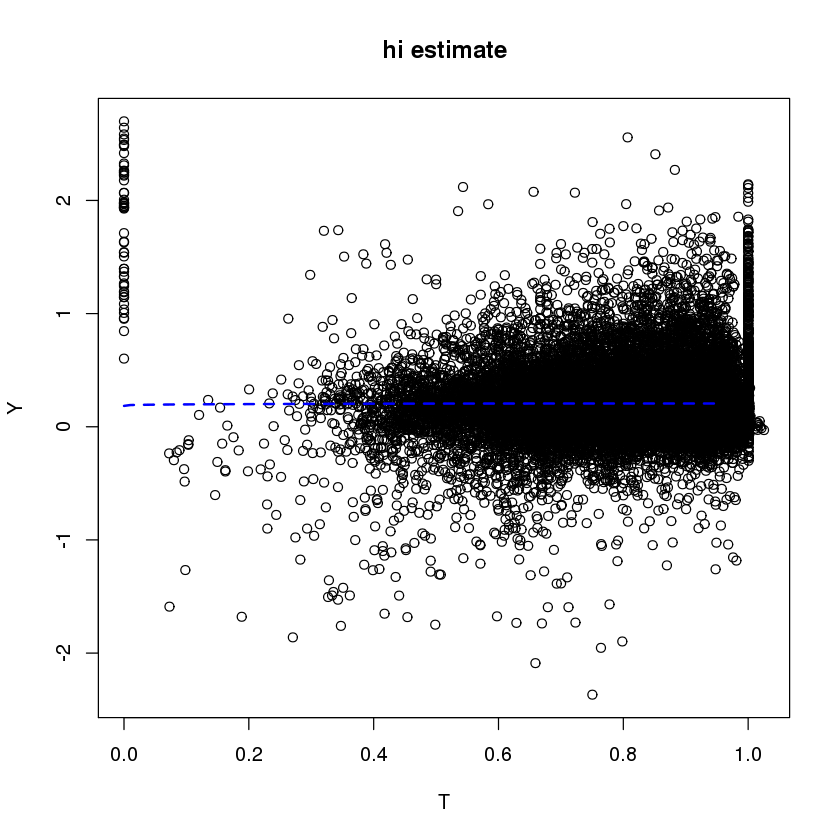

In [165]:
# example plot
plot(tmp_data[['T']], tmp_data[['Y']], xlab="T", ylab="Y", main="hi estimate")
N <- length(hi_estimate[['param']])-1
lines(quant_probs, hi_estimate[['param']], lty=2, lwd=2, col='blue')

That fit looks pretty bad! But maybe if we bootstrap a bunch then we'll see a tighter fit.

In [188]:
set.seed(123)
test <- replicate(2, sample(10,10,replace = TRUE))
print(test[, 1])

 [1]  3  8  5  9 10  1  6  9  6  5


In [191]:
# example bootstrap
# one treatment var to start, just frequency as cvar, k=12
set.seed(123)
t_var <- c('DL')
c_vars <- c('f')
k <- 12
o_var <- paste(c('f_delta_', k), collapse='')
tmp_data <- as.data.frame(cbind(stats_combined_change_words[, t_var], stats_combined_change_words[, c_vars], stats_combined_change_words[, o_var]))
colnames(tmp_data) <- c('T', c_vars, 'Y')
# only include valid cases
tmp_data <- tmp_data[complete.cases(tmp_data[, 'Y']), ]
grid_val <- quantile(tmp_data[,'T'], probs=quant_probs)
# automatically generate formulae
treat_formula_str <- paste('T', paste(c_vars, collapse = '+'), sep = '~')
outcome_formula_str <- paste('Y', paste(c('T', 'gps'), collapse = '+'), sep = '~')
# convert estimator command to text and parse
hi_est_str <- paste(c("hi_est(Y=Y, treat=T, treat_formula=",treat_formula_str, ",outcome_formula=",
                      outcome_formula_str, ",data=tmp_data_sample, grid_val=grid_val, treat_mod='Normal', link_function='inverse')"), 
                    collapse="")
hi_bootstrap_df <- data.frame()
bootstrap_iters <- 100
N <- nrow(tmp_data)
sample_idx_matrix <- replicate(bootstrap_iters, sample(N, N, replace=TRUE))
for(i in 1:bootstrap_iters){
    print(paste('iter=', i, sep=''))
    sample_idx <- sample_idx_matrix[, i]
    tmp_data_sample <- tmp_data[sample_idx, ]
    hi_estimate <- eval(parse(text=hi_est_str))
    print(hi_estimate$t_mod)
    print(hi_estimate$out_mod)
    hi_coeffs <- hi_estimate[['out_mod']][['coefficients']]
    hi_est_row <- c(k, t_var, c_var_str, hi_coeffs[['T']], hi_coeffs[['gps']], hi_coeffs[['(Intercept)']], i)
    hi_est_row <- t(data.frame(hi_est_row))
    if(length(hi_est_df) == 0){
        hi_bootstrap_df <- hi_est_row
    }
    else{
        hi_bootstrap_df <- as.data.frame(rbind(hi_bootstrap_df, hi_est_row))
    }
}
hi_est_colnames <- c('k', 'treatment_name', 'control_names', 'treatment_coeff', 'gps_coeff', 'intercept_coeff', 'iter')
colnames(hi_bootstrap_df) <- hi_est_colnames

[1] "iter=1"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   -0.35550     -0.06725  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.20007      0.05279     -0.02697  

[1] "iter=2"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   -0.36956     -0.06921  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.17478      0.04661     -0.01477  

[1] "iter=3"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   -0.36410     -0.06895  


Call:
lm(formula = outcome_formula, data = tempdat)

Coefficients:
(Intercept)            T          gps  
    0.20483      0.04968     -0.02980  

[1] "iter=4"

Call:
lm(formula = formula_t, data = samp_dat)

Coefficients:
(Intercept)            f  
   -0.34179     -0.06547  


Call:
lm(formula = outcome_f

In [204]:
head(as.vector(hi_bootstrap_df[, 'treatment_coeff']))

[1] 0.05278644 0.04661010 0.04968289 0.04472383 0.03615234 0.03805245

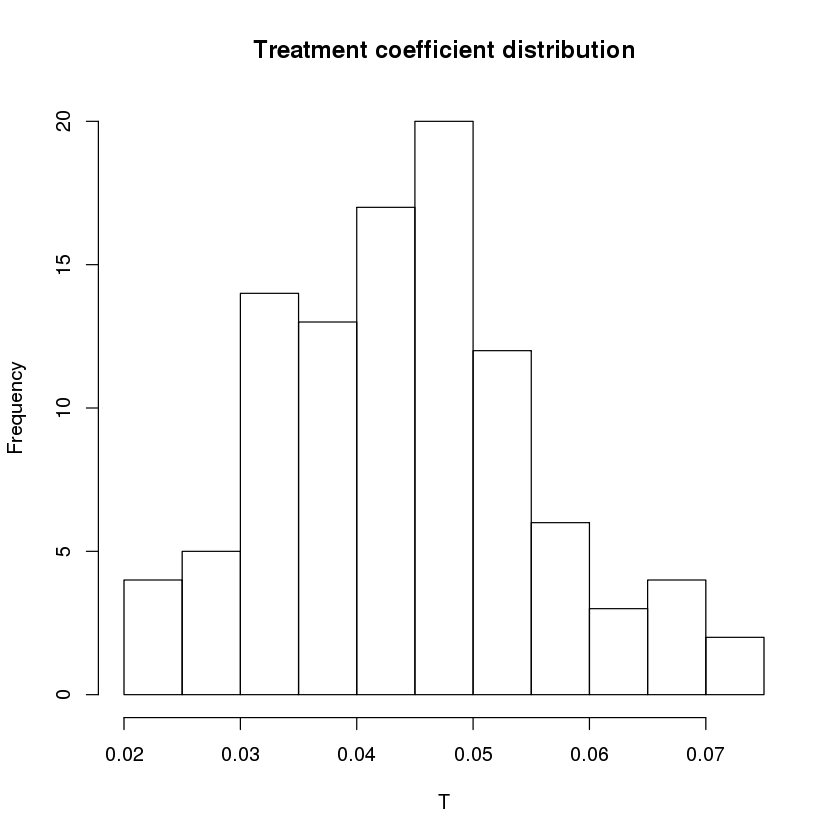

In [211]:
# visualize spread of treatment coefficients
hist(as.double(as.vector(hi_bootstrap_df[, 'treatment_coeff'])), main = 'Treatment coefficient distribution', xlab = 'T')

Looks like a normal distribution to me! Let's get a confidence interval.

In [223]:
print(treatment_sd)

[1] 0.001126794


In [219]:
# 95% confidence intervals
treatment_coeff_vals <- as.double(as.vector(hi_bootstrap_df[, 'treatment_coeff']))
treatment_mu <- mean(treatment_coeff_vals)
treatment_sd <- sd(treatment_coeff_vals) / length(treatment_coeff_vals)**.5
conf_size <- 0.975
conf_mult <- qnorm(conf_size)
conf_int_size <- conf_mult*treatment_sd
lower_bound <- treatment_mu - conf_int_size
upper_bound <- treatment_mu + conf_int_size
print(paste(c('[', lower_bound, ',', upper_bound, ']'), collapse = ''))

[1] "[0.0422132785372101,0.0466302295276977]"


### Plot confidence intervals
Let's try to replicate the confidence intervals from the tutorial with one of the situations we've figured out:

- all words, controls=all variables, treatment=DL

In [146]:
print(get_ci)

function (grid_val, coef_mat, degree) 
{
    if (degree == 1) {
        grid_ci <- matrix(numeric(length(grid_val) * nrow(coef_mat)), 
            nrow = nrow(coef_mat))
        for (i in 1:nrow(coef_mat)) {
            grid_ci[i, ] <- coef_mat[i, 1] + coef_mat[i, 2] * 
                grid_val
        }
        param_sorted <- apply(coef_mat, 2, sort, decreasing = F)
        ci_sorted <- apply(grid_ci, 2, sort, decreasing = F)
        upper_ci <- ci_sorted[ceiling(0.975 * nrow(coef_mat)), 
            ]
        lower_ci <- ci_sorted[floor(0.025 * nrow(coef_mat)), 
            ]
        ci_est <- rbind(upper_ci, lower_ci)
    }
    else if (degree == 2) {
        grid_ci <- matrix(numeric(length(grid_val) * nrow(coef_mat)), 
            nrow = nrow(coef_mat))
        for (i in 1:nrow(coef_mat)) {
            grid_ci[i, ] <- coef_mat[i, 1] + coef_mat[i, 2] * 
                grid_val + coef_mat[i, 3] * grid_val^2
        }
        param_sorted <- apply(coef_mat, 2, sort, decreasing = F)

## 